In [1]:
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF
import sklearn.metrics as m # Metrics to determine the classification 

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

In [17]:
# Set seed
np.random.seed(123)

# read in the data
turnout = pd.read_csv("../turnout.csv")

In [18]:
# drop id because it can't be used for prediction
turnout.drop(["id"], axis =1, inplace=True)

In [19]:
# Break the data up into a training set and a testing set
train = turnout.sample(frac=.8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop=True)

In [20]:
# Make sure we have the right amount of observations in each 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

Training Data: 1600 
Test Data: 400


In [21]:
# Look at the head of the data
train.head()

,age,educate,income,vote,white
0,26,12.0,1.6049,0,1
1,35,14.0,8.7517,1,1
2,17,14.0,6.7838,1,1
3,24,16.0,6.7838,1,1
4,27,12.0,4.8901,0,1


## Binary Variable: Race

In [22]:
# First we calculate the probability of the classes aka, how likely is it for an indivudual to vote

# total number of observations
N = train.shape[0]

# break apart by voted or didn't vote
voted = train.query("vote == 1")
didnt_vote = train.query("vote == 0")

# calculate the probabilities of each class
pr_voted = voted.shape[0]/N
pr_novote = didnt_vote.shape[0]/N

# print the probabilities
print("The probability that an individual voted is:", pr_voted)
print("Thd probabilty that an individual did not vote is:", pr_novote)

The probability that an individual voted is: 0.744375
Thd probabilty that an individual did not vote is: 0.255625


In [23]:
# Next we calculate the conditional probabilities, the probability we'll see a particular value for our variables given the class

# race given voted = 1
w1_v1 = voted.query("white == 1").shape[0]/voted.shape[0]
w0_v1 = voted.query("white == 0").shape[0]/voted.shape[0]   

# race given voted = 0
w1_v0 = didnt_vote.query("white == 1").shape[0]/didnt_vote.shape[0]
w0_v0 = didnt_vote.query("white == 0").shape[0]/didnt_vote.shape[0] 

In [24]:
print("The probability that an individual voted and is white:", w1_v1)
print("The probabilty that an individual voted and is not white:", w0_v1)
print("The probability that an individual did not vote and is white:", w1_v0)
print("The probabilty that an individual did not vote and is not white:", w0_v0)

The probability that an individual voted and is white: 0.8723761544920235
Thd probabilty that an individual voted and is not white: 0.12762384550797648
The probability that an individual did not vote and is white: 0.7897310513447433
The probabilty that an individual did not vote and is not white: 0.21026894865525672


In [25]:
# save the conditional probabilities to a dictionary
cond_probs = {('white', 0, 0): w0_v0, ('white', 0, 1): w0_v1,
('white', 1, 0): w1_v0, ('white', 1, 1): w1_v1}

In [26]:
# save the class probabilities to a dictionary
class_probs = {0: pr_novote, 1:pr_voted}

## Continuous Variables: Age, Education, Income

In [27]:
# For continuous variables we calculate the probabilities based on their distributions

# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("age",1):{'mean':voted.age.mean(),'sd':voted.age.std()},
 ("age",0):{'mean':didnt_vote.age.mean(),'sd':didnt_vote.age.std()},
 ("educate",1):{'mean':voted.educate.mean(),'sd':voted.educate.std()},
 ("educate",0):{'mean':didnt_vote.educate.mean(),'sd':didnt_vote.educate.std()},
 ("income",1):{'mean':voted.income.mean(),'sd':voted.income.std()},
 ("income",0):{'mean':didnt_vote.income.mean(),'sd':didnt_vote.income.std()}
}

# Print
pp.pprint(dist_locs)

{('age', 0): {'mean': 42.75061124694376, 'sd': 18.8781283829491},
 ('age', 1): {'mean': 46.17044500419815, 'sd': 16.751831698772214},
 ('educate', 0): {'mean': 10.62836185819071, 'sd': 3.144794563899187},
 ('educate', 1): {'mean': 12.563811922753988, 'sd': 3.313411795406922},
 ('income', 0): {'mean': 2.7642088019559896, 'sd': 2.129945763720976},
 ('income', 1): {'mean': 4.251116288832915, 'sd': 2.9178548707903462}}


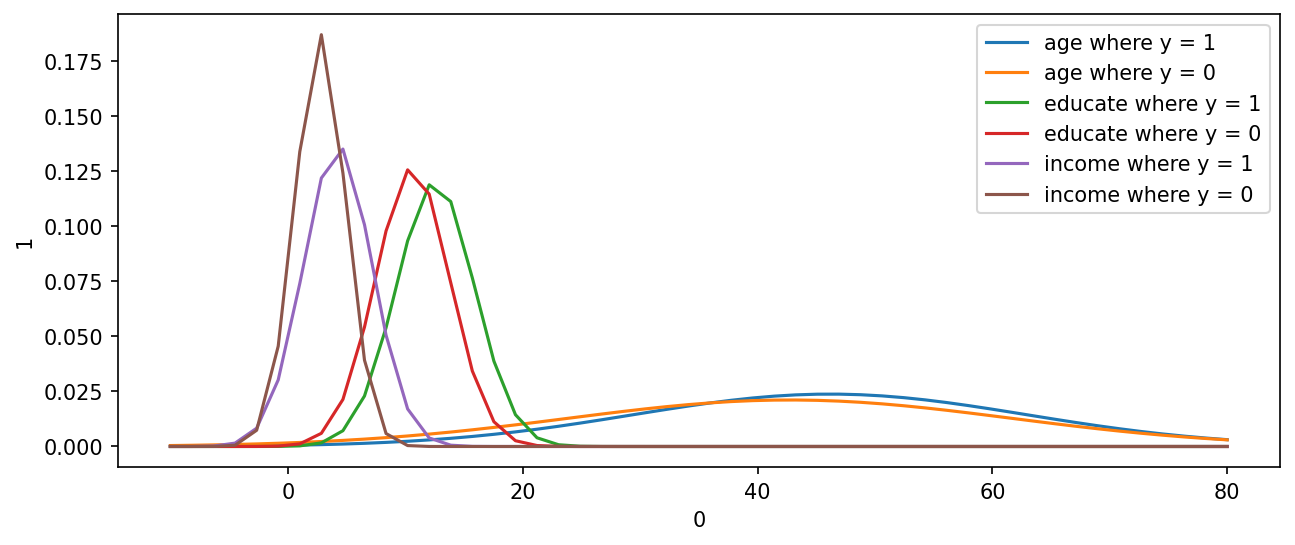

In [28]:
# Plot the approximate distributions of our variables with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-10,80)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")

In [29]:
# Here we'll manually calculate the prediction for the first row of our training data

# reorder columns
train = train[["vote","age","educate","income","white"]]

# save and print value of the variables in the first row
vote, age, educate, income, white = train.iloc[1,:]
print(vote, age, educate, income, white)

1.0 35.0 14.0 8.7517 1.0


In [30]:
# Prediction for the 1 class
# For the continuous variables calculate where the values of the variables fall on the distribution and save them as a, b, and c
a = st.norm(dist_locs[("age",1)]['mean'], dist_locs[("age",1)]['sd']).pdf(age)
b = st.norm(dist_locs[("educate",1)]['mean'], dist_locs[("educate",1)]['sd']).pdf(educate)
c = st.norm(dist_locs[("income",1)]['mean'], dist_locs[("income",1)]['sd']).pdf(income)
# for the binary variables use the probability that they did vote and are not white
d = w1_v1
# save the class probability as e
e = pr_voted
# multiply to find the probability
pr_1 = a * b * c * d * e

# For the prediction for the 0 class do the same as above
a = st.norm(dist_locs[("age",0)]['mean'], dist_locs[("age",0)]['sd']).pdf(age)
b = st.norm(dist_locs[("educate",0)]['mean'], dist_locs[("educate",0)]['sd']).pdf(educate)
c = st.norm(dist_locs[("income",0)]['mean'], dist_locs[("income",1)]['sd']).pdf(income)
d = w1_v0
e = pr_novote
pr_0 = a * b * c * d * e

print(
f'''
    Pr(v == 1| X): {pr_1}
    Pr(v == 0| X): {pr_0}
''')


    Pr(v == 1| X): 5.647565865165419e-05
    Pr(v == 0| X): 4.662646784579677e-06



Because the probability that they did vote is slighly higher than the probability that they did not vote, we predict that they did vote, which in this instance is correct.

## Build a Naive Bayes Classifier

### The equation of the naive bayes classifier:
$$Pr(class | data) = Pr( x_1| class)\times Pr( x_2| class) \times \dots \times  Pr(class)$$

### From the above equation we can derive the equation for our model
$$Pr(vote | data) = Pr( age| class)\times Pr( race| class) \times Pr( income| class) \times Pr( education| class)\times  Pr(vote)$$

In [31]:
# To do what we did for the first row for multiple observations we need to build a classifier

# Our classifier will take the form of a function. Here we create a function that combs through the data and based on the conditional probabilities makes a prediction about what class it will fall into 

def predict(data,class_probs,cond_probs,dist_locs,binary):
    '''
   Based on the conditional probabilites of the binary variables and the distributions of the continuous variables, the function will calculate the probablity of each class and predict the most likely one.
    It takes as an arguement the data, class probabilities, conditional probabilities of binary variables, distributions of the continuous variables, and the name of our binary variables
    '''
    # create an empty list to store predictoins
    store_preds = []
    # itterate through the rows od the data
    for i,row in data.iterrows():
        # set values of probabilities to one so that we can multiply by the probability
        pr_1 = 1; pr_0 = 1
        # iterate through each row
        for j in range(1,len(row.index)):
            # determine if this is a binary variable
            if row.index[j] in binary:
                # for the values of the variables in each row look                    up the probability when vote = 1 and 0
                pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
                pr_1 *= cond_probs[(row.index[j],row.values[j],1)]              # if continuous:
            else:
                # Get the predictions using a Gaussan distribution
                pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'],
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        # multiply by the probability of each class
        pr_0 *= class_probs[0]
        pr_1 *= class_probs[1]
        # choose the higher value as the prediction
        if pr_0 >= pr_1:
            pred = 0
        else:
            pred = 1   
        # append values to store_preds and make the prediction dependent on the higher value
        store_preds.append([pr_0,pr_1,pred])
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run the function and show the resulting prediction table
preds = predict(train, class_probs, cond_probs, dist_locs, "white")
preds.head()

,pr_0,pr_1,pred
0,0.000054,0.000081,1
1,0.000001,0.000056,1
2,0.000004,0.000035,1
3,0.000002,0.000042,1
4,0.000040,0.000127,1


In [32]:
# calculate the predictive accuracy on the training data
accuracy = sum(train.vote == preds.pred)/train.shape[0]
accuracy

0.739375

In [33]:
# Reorder the test set to match the training set
test = test[["vote","age","educate","income","white"]]
# Run our prediction model on the test data and calculate the prediction accuracy
test_preds = predict(test, class_probs, cond_probs, dist_locs,"white")
test_accuracy = sum(test.vote == test_preds.pred)/test.shape[0]
test_accuracy

0.715

In [34]:
# pull out just the predictions from test_preds so we can use it with sklearn.metrics
predictions = test_preds["pred"]

In [35]:
# Organize our data so it plugs into the sklearn API easily 
train_y = train['vote']
train_x = train[['white']]
test_y = test['vote']
test_x = test[['white']]

In [36]:
# test the accuracy using sklearn.metrics
m.accuracy_score(test_y, predictions)

0.715

In [37]:
# area under roc curve
m.roc_auc_score(test_y,predictions)

0.5821428571428571

In [38]:
# generate an ROC curve

# first we need probabilities and not predictions
probabilities = test_preds[["pr_0", "pr_1"]].rename({"pr_0":0.0, "pr_1":1.0}, axis = 'columns')

probabilities.head()

,0.0,1.0
0,0.000004,0.000014
1,0.000020,0.000179
2,0.000030,0.000067
3,0.000079,0.000184
4,0.000001,0.000042


In [39]:
# now we need false positive and true postive rates
fpr, tpr, thresholds = m.roc_curve(test_y, probabilities[1])

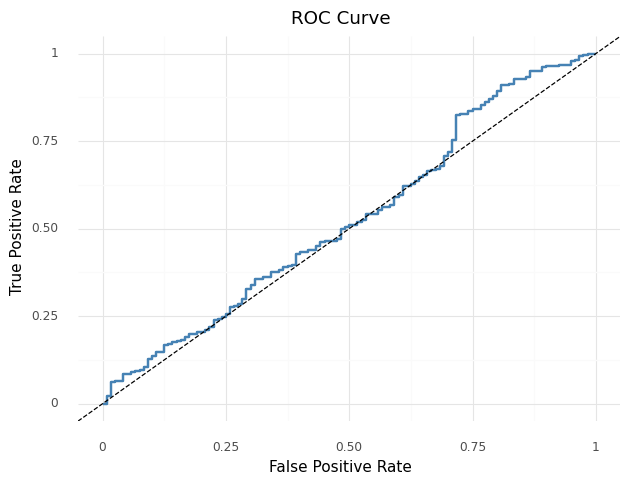

<ggplot: (298083919)>

In [44]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve", x="False Positive Rate", y = "True Positive Rate") +
    theme(figure_size=(7,5))
)

## Summarize the results of the model

When applies to our test data, the model has an accuracy of 71.5%. This is pretty bad when you take into account that (if we assume our training data is representative which it should be) we'd get a similar number if we just guessed that every single person voted. 

The ROC AUC score is 0.58. This score represents the area under the ROC curve and is slighly above what would be expected for a random classifier (0.5). Thus the ROC curve tells us that our model is slightly better than what we would expect from a random classifier and just pure chance, but not by that much. 

The poor accuracy and poor AUC score tells us that as a whole our model is pretty bad at predicting whether someone will vote.